In [1]:
library(leaps)
library(sp)
library(glmnet)
library(pls)
library(ISLR)
library(ggpubr)

# consideramos todos los modelos hasta 10 predictoras
regfit.todos <- regsubsets( Sales ~ ., Carseats, nvmax = 10 )
reg.summary <- summary( regfit.todos )
reg.summary

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 

Loading required package: Matrix

Loaded glmnet 4.1-7


Attaching package: 'pls'


The following object is masked from 'package:stats':

    loadings


Loading required package: ggplot2



Subset selection object
Call: regsubsets.formula(Sales ~ ., Carseats, nvmax = 10)
11 Variables  (and intercept)
                Forced in Forced out
CompPrice           FALSE      FALSE
Income              FALSE      FALSE
Advertising         FALSE      FALSE
Population          FALSE      FALSE
Price               FALSE      FALSE
ShelveLocGood       FALSE      FALSE
ShelveLocMedium     FALSE      FALSE
Age                 FALSE      FALSE
Education           FALSE      FALSE
UrbanYes            FALSE      FALSE
USYes               FALSE      FALSE
1 subsets of each size up to 10
Selection Algorithm: exhaustive
          CompPrice Income Advertising Population Price ShelveLocGood
1  ( 1 )  " "       " "    " "         " "        " "   "*"          
2  ( 1 )  " "       " "    " "         " "        "*"   "*"          
3  ( 1 )  "*"       " "    " "         " "        "*"   "*"          
4  ( 1 )  "*"       " "    "*"         " "        "*"   "*"          
5  ( 1 )  "*"       " "    "*"

In [3]:
# definimos puntos óptimos para c/ criterio, guardamos su posición
max_adjr2 = which.max(reg.summary$adjr2)

min_cp=which.min(reg.summary$cp)

min_bic=which.min(reg.summary$bic)

which.min(reg.summary$aic)

sal_reg=data.frame(orden=1:10,adjr2=reg.summary$rsq,Cp=reg.summary$cp,Bic=reg.summary$bic)

integer(0)

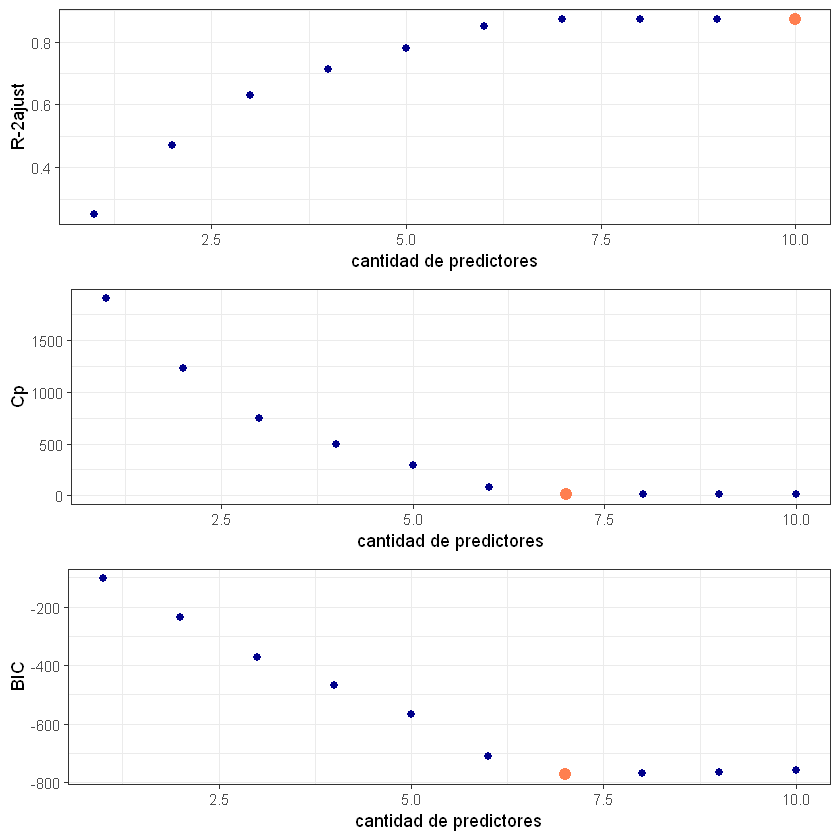

In [3]:
# graficamos los valores de c/ criterio en función de la cantidad de predictores
pl1 <- ggplot( sal_reg, aes( orden,adjr2 ) ) +
        geom_point( size=2, col="darkblue" ) +
    theme_bw() +
    xlab( "cantidad de predictores" ) +
    ylab( "R-2ajust" ) +
        geom_point( aes( max_adjr2, reg.summary$adjr2[max_adjr2] ),
            size=3,
            color="coral" )

pl2 <- ggplot( sal_reg,aes(orden,Cp) ) +
        geom_point( size=2, col="darkblue" ) +
    theme_bw() +
    xlab( "cantidad de predictores" ) +
    ylab( "Cp" ) +
        geom_point( aes( min_cp,reg.summary$cp[min_cp] ), 
        size=3, 
        color="coral" )

pl3 <- ggplot( sal_reg, aes(orden,Bic) ) +
        geom_point( size=2, col="darkblue" ) +
    theme_bw() +
    xlab( "cantidad de predictores" ) +
    ylab( "BIC" ) +
        geom_point( aes( min_bic, reg.summary$bic[min_bic] ), 
        size=3,
        color="coral" )

ggarrange( pl1, pl2, pl3, ncol=1 )

In [8]:
# buscamos los coeficientes del modelo con 7 predictores
as.data.frame(  coef( regfit.todos, 7 ) )

,"coef(regfit.todos, 7)"
,<dbl>
(Intercept),5.47522623
CompPrice,0.09257147
Income,0.01578497
Advertising,0.11590340
Price,-0.09531895
ShelveLocGood,4.83567475
ShelveLocMedium,1.95199266
Age,-0.04612752


In [2]:
# fijamos una semilla y elegimos un 80% de los datos para entrenar el modelo y el 20% para validarlo
set.seed(1123)
n = nrow(Carseats)
index = sample(n, n*0.80, replace = FALSE)
train_set = Carseats[index,]
dim(train_set)
test_set = Carseats[-index,]
dim(test_set)
# modelo completo con todas las variables
model_full = lm(Sales ~ ., data = train_set)
# modelo s´olo con intercepto
model_int = lm(Sales ~ ., data = train_set)

[1] 320  11

[1] 80 11

### Fordward

In [3]:
scopeformula = formula( model_full )
scopeformula
fwd_sel = step( object=model_int, scope=scopeformula, direction="forward" )
summary( fwd_sel )
FwdSelection_AIC = AIC( fwd_sel )

Sales ~ CompPrice + Income + Advertising + Population + Price + 
    ShelveLoc + Age + Education + Urban + US

Start:  AIC=17.35
Sales ~ CompPrice + Income + Advertising + Population + Price + 
    ShelveLoc + Age + Education + Urban + US




Call:
lm(formula = Sales ~ CompPrice + Income + Advertising + Population + 
    Price + ShelveLoc + Age + Education + Urban + US, data = train_set)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.85113 -0.72879  0.03737  0.69352  2.59430 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      5.761e+00  6.767e-01   8.513 7.56e-16 ***
CompPrice        9.433e-02  4.628e-03  20.383  < 2e-16 ***
Income           1.564e-02  2.052e-03   7.623 3.10e-13 ***
Advertising      1.300e-01  1.250e-02  10.403  < 2e-16 ***
Population      -4.357e-05  4.192e-04  -0.104   0.9173    
Price           -9.406e-02  2.945e-03 -31.944  < 2e-16 ***
ShelveLocGood    4.835e+00  1.685e-01  28.699  < 2e-16 ***
ShelveLocMedium  1.927e+00  1.425e-01  13.525  < 2e-16 ***
Age             -4.516e-02  3.460e-03 -13.054  < 2e-16 ***
Education       -3.797e-02  2.188e-02  -1.735   0.0837 .  
UrbanYes         2.914e-02  1.259e-01   0.231   0.8172    
USYes           -4.275e-

### Backwards

In [20]:
model_full = lm( Sales ~ ., data = train_set )
scopeformula = formula( model_full )
back_sel = step( object=model_full, scope=scopeformula, direction="backward" )
summary( back_sel )
BackSelection_AIC = AIC( back_sel )
BackSelection_AIC

Start:  AIC=17.35
Sales ~ CompPrice + Income + Advertising + Population + Price + 
    ShelveLoc + Age + Education + Urban + US

              Df Sum of Sq     RSS    AIC
- Population   1      0.01  313.43  15.37
- Urban        1      0.05  313.48  15.41
<none>                      313.42  17.35
- Education    1      3.06  316.49  18.47
- US           1      6.60  320.02  22.02
- Income       1     59.13  372.55  70.66
- Advertising  1    110.12  423.54 111.70
- Age          1    173.40  486.82 156.26
- CompPrice    1    422.79  736.21 288.62
- ShelveLoc    2    857.92 1171.34 435.23
- Price        1   1038.40 1351.82 483.08

Step:  AIC=15.37
Sales ~ CompPrice + Income + Advertising + Price + ShelveLoc + 
    Age + Education + Urban + US

              Df Sum of Sq     RSS    AIC
- Urban        1      0.06  313.49  13.43
<none>                      313.43  15.37
- Education    1      3.08  316.51  16.49
- US           1      6.81  320.25  20.25
- Income       1     59.22  372.66  68.75


Call:
lm(formula = Sales ~ CompPrice + Income + Advertising + Price + 
    ShelveLoc + Age + Education + US, data = train_set)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.84445 -0.71933  0.04001  0.70172  2.56364 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      5.753434   0.639369   8.999  < 2e-16 ***
CompPrice        0.094424   0.004593  20.557  < 2e-16 ***
Income           0.015657   0.002045   7.657 2.45e-13 ***
Advertising      0.129627   0.011772  11.012  < 2e-16 ***
Price           -0.094050   0.002928 -32.118  < 2e-16 ***
ShelveLocGood    4.830131   0.166110  29.078  < 2e-16 ***
ShelveLocMedium  1.923895   0.140567  13.687  < 2e-16 ***
Age             -0.045104   0.003442 -13.103  < 2e-16 ***
Education       -0.037797   0.021574  -1.752  0.08076 .  
USYes           -0.423767   0.163209  -2.596  0.00987 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.006 on 310 degrees o

[1] 923.5469

### Stepwise

In [23]:
both_sel = step( object=model_full, scope=scopeformula, direction="both" )
summary(both_sel)
BidirSelection_AIC = AIC(both_sel)
BidirSelection_AIC
AIC_df = data.frame(FwdSelection=FwdSelection_AIC, BackSelection=BackSelection_AIC, BidirSelection=BidirSelection_AIC)
rownames(AIC_df) = c("AIC")
AIC_df

Start:  AIC=17.35
Sales ~ CompPrice + Income + Advertising + Population + Price + 
    ShelveLoc + Age + Education + Urban + US

              Df Sum of Sq     RSS    AIC
- Population   1      0.01  313.43  15.37
- Urban        1      0.05  313.48  15.41
<none>                      313.42  17.35
- Education    1      3.06  316.49  18.47
- US           1      6.60  320.02  22.02
- Income       1     59.13  372.55  70.66
- Advertising  1    110.12  423.54 111.70
- Age          1    173.40  486.82 156.26
- CompPrice    1    422.79  736.21 288.62
- ShelveLoc    2    857.92 1171.34 435.23
- Price        1   1038.40 1351.82 483.08

Step:  AIC=15.37
Sales ~ CompPrice + Income + Advertising + Price + ShelveLoc + 
    Age + Education + Urban + US

              Df Sum of Sq     RSS    AIC
- Urban        1      0.06  313.49  13.43
<none>                      313.43  15.37
- Education    1      3.08  316.51  16.49
+ Population   1      0.01  313.42  17.35
- US           1      6.81  320.25  20.25


Call:
lm(formula = Sales ~ CompPrice + Income + Advertising + Price + 
    ShelveLoc + Age + Education + US, data = train_set)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.84445 -0.71933  0.04001  0.70172  2.56364 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      5.753434   0.639369   8.999  < 2e-16 ***
CompPrice        0.094424   0.004593  20.557  < 2e-16 ***
Income           0.015657   0.002045   7.657 2.45e-13 ***
Advertising      0.129627   0.011772  11.012  < 2e-16 ***
Price           -0.094050   0.002928 -32.118  < 2e-16 ***
ShelveLocGood    4.830131   0.166110  29.078  < 2e-16 ***
ShelveLocMedium  1.923895   0.140567  13.687  < 2e-16 ***
Age             -0.045104   0.003442 -13.103  < 2e-16 ***
Education       -0.037797   0.021574  -1.752  0.08076 .  
USYes           -0.423767   0.163209  -2.596  0.00987 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.006 on 310 degrees o

[1] 923.5469

,FwdSelection,BackSelection,BidirSelection
,<dbl>,<dbl>,<dbl>
AIC,927.4745,923.5469,923.5469
